In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [2]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import os

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

from utils import general_utils
import deformation.losses as def_losses
from utils.visualization_tools import show_refinement_results


In [3]:
def get_exp_path(exp_name):
    if os.path.exists(os.path.join("out",exp_name)):
        return exp_name
    
    if exp_name == "latest":
        exp_paths = []
        for root, dirs, files in os.walk("out"):
            for d in dirs:
                if "--" in d and len(os.path.join(root,d).split('/'))==2:
                    exp_paths.append(d)
        return sorted(exp_paths)[-1]
    
    exp_path = []
    for root, dirs, files in os.walk("out"):
        for d in dirs:
            if exp_name == d[21:] and len(os.path.join(root,d).split('/'))==2:
                exp_path.append(d)
    if len(exp_path) > 1:
        print(exp_path)
        raise Exception("multiple experiments with that name")
    elif len(exp_path) == 0:
        raise Exception("Couldn't find any matching experiments")
    else:
        return exp_path[0]

In [8]:
n="airplane_job_05"
saved_model_path = "out/{}".format(get_exp_path(n))
print(saved_model_path)
cfg_path = glob.glob(os.path.join(saved_model_path, "job_*.yaml"))[0]
print(cfg_path)
cfg = general_utils.load_config(cfg_path, "configs/default.yaml")

gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))

out/2020_12_29--05_03_37_airplane_job_05
out/2020_12_29--05_03_37_airplane_job_05/job_05.yaml


# Show Adversarial Training Info

In [ ]:


# showing discriminator plots
training_info = pickle.load(open(os.path.join(saved_model_path, "training_df.p"), "rb"))
semantic_dis_training_df = training_info["semantic_dis"]
if not semantic_dis_training_df.empty:
    # adding extra column for fracitional iteration
    iteration_fractional = np.linspace(0, max(semantic_dis_training_df['iteration'])+1, len(semantic_dis_training_df)+1)[:-1]
    semantic_dis_training_df["iteration_fractional"] = iteration_fractional
    print(semantic_dis_training_df.isnull().values.any())
    
    #pd.set_option('display.max_rows', None)  
    #display(semantic_dis_training_df)
    semantic_dis_training_df.plot.line(x="iteration_fractional", y="semantic_dis_loss", title="DIS Train: " + saved_model_path, color='r', ylim=(0,8))
    #semantic_dis_training_df.plot.line(x="iteration_fractional", y="batch_avg_dis_acc", title="DIS Train: " + saved_model_path, color='r')

# showing generator (deformation net) plots
deform_gen_training_df = training_info["deform_net_gen"]
if not deform_gen_training_df.empty:
    iteration_fractional = np.linspace(0, max(deform_gen_training_df['iteration'])+1, len(deform_gen_training_df)+1)[:-1]
    deform_gen_training_df["iteration_fractional"] = iteration_fractional
    #display(deform_gen_training_df)

    deform_gen_training_df.plot.line(x="iteration_fractional", y="semantic_dis_loss", title=saved_model_path, ylim=(0,8))
    #deform_gen_training_df.plot.line(x="iteration_fractional", y="total_loss", title=saved_model_path)
    #deform_gen_training_df.plot.line(x="iteration_fractional", y="sil_loss", title=saved_model_path)

# Show Adversarial Training Results

In [6]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, only_show_instances=[], num_novel_view=3, print_instances=False, descending=True, early_break=True):
    input_dir_img = cfg['semantic_dis_training']['gen_dir_img']
    input_dir_mesh = cfg['semantic_dis_training']['gen_dir_mesh']
    
    cached_pred_poses = pickle.load(open(cfg['semantic_dis_training']["gen_poses"], "rb"))
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in sorted(processed_paths_dict[instance_name], key= lambda x : int(str(x).split('/')[-2].replace("eval_", "")), reverse=descending):
                if print_instances:
                    print(instance_name)
                    print(processed_mesh_path)
                    
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                with torch.no_grad():
                    mesh_original = general_utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                    mesh_processed = general_utils.load_untextured_mesh(processed_mesh_path, device)

                # rendering original and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                
                show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device)
                if early_break:
                    break

Latest eval dir: out/2020_12_29--05_03_37_airplane_job_05/eval_0630

d583d6f23c590f3ec672ad25c77a396
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d583d6f23c590f3ec672ad25c77a396.obj


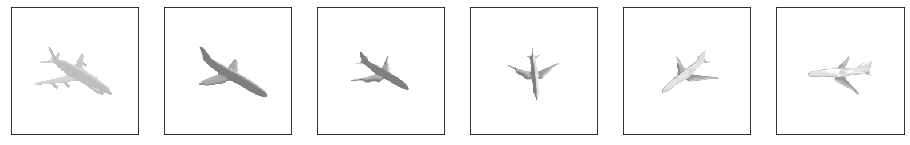

f4b734236ec678d269e10d525d6df27
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f4b734236ec678d269e10d525d6df27.obj


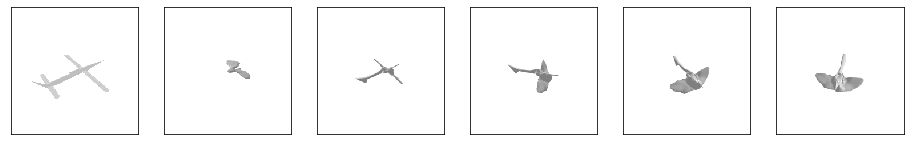

f016679500a76fbd8badc4a9f1acc937
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f016679500a76fbd8badc4a9f1acc937.obj


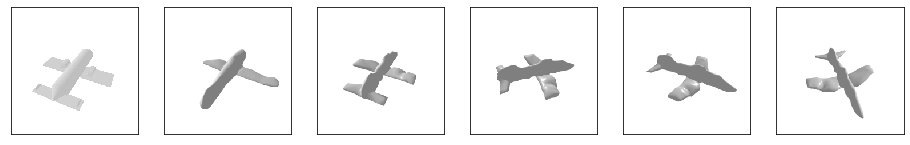

e8289fd7e6ab0df4d37636af9c7bcc34
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e8289fd7e6ab0df4d37636af9c7bcc34.obj


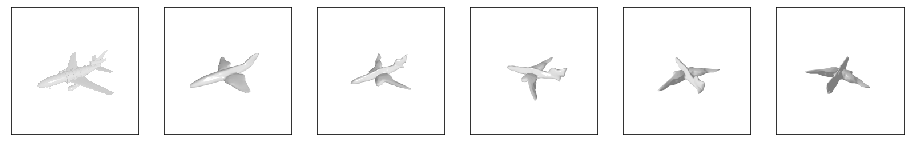

d74767519393a937f73e5bc170b7e2be
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d74767519393a937f73e5bc170b7e2be.obj


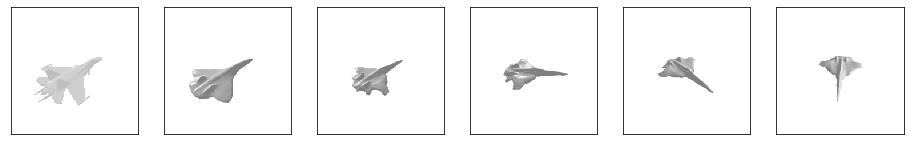

d883e6e5622a0cab72351dbf9e0687e0
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d883e6e5622a0cab72351dbf9e0687e0.obj


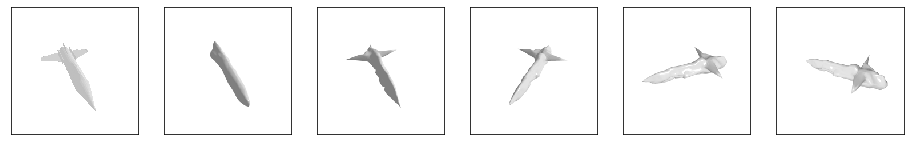

db758090dd739ee9ca68a659ecae961c
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/db758090dd739ee9ca68a659ecae961c.obj


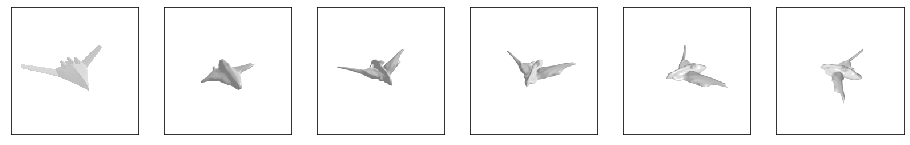

f485dcbd466f217286774cad40dd456a
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f485dcbd466f217286774cad40dd456a.obj


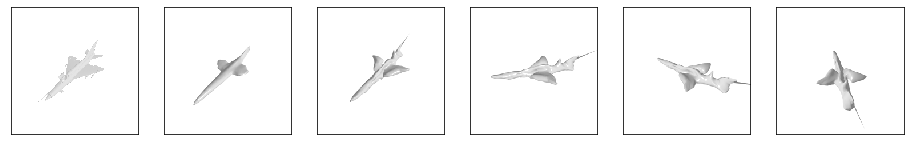

ed7e1a38fe33830b87697d3904b168b
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/ed7e1a38fe33830b87697d3904b168b.obj


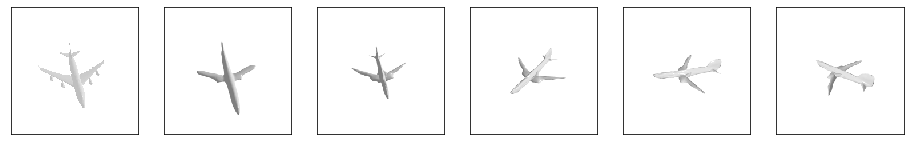

e805624480f632ebcc14f1e6f4f4f49b
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e805624480f632ebcc14f1e6f4f4f49b.obj


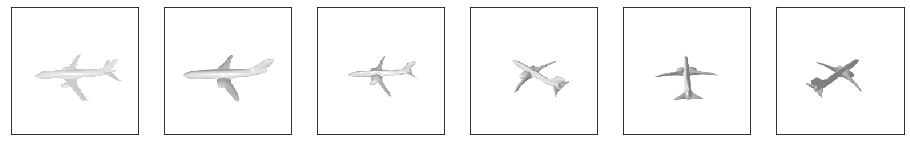

de1a7b4e9911e48b48e8405d6c51a908
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/de1a7b4e9911e48b48e8405d6c51a908.obj


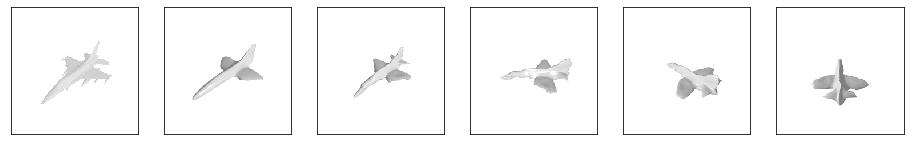

f5403d3ffcc6bb17adce4f2283adbdbd
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f5403d3ffcc6bb17adce4f2283adbdbd.obj


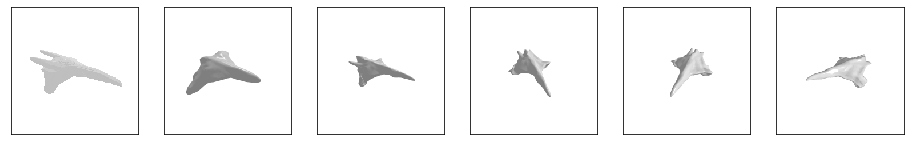

d3f93b6da62fae46a98ae8c73b190485
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d3f93b6da62fae46a98ae8c73b190485.obj


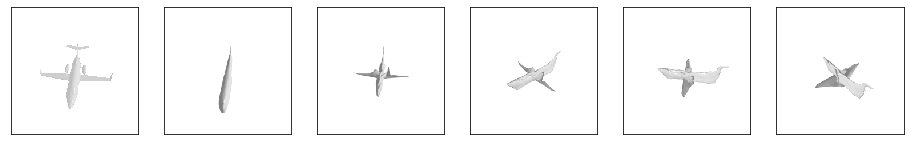

e0b5c450de6d7fe3d87c63d8b3018b58
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e0b5c450de6d7fe3d87c63d8b3018b58.obj


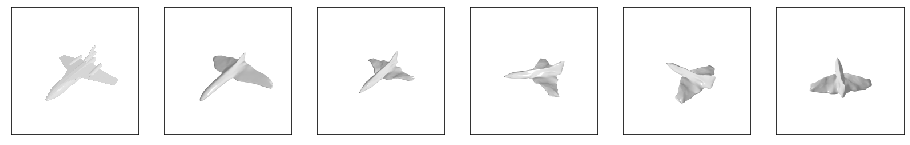

e9f39176973edd33a8cba409c4409ba9
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e9f39176973edd33a8cba409c4409ba9.obj


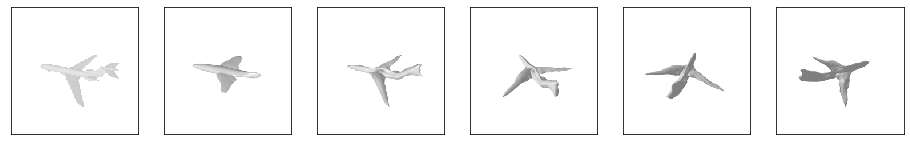

de9564aeaa585a6ccbc790a63192d2ab
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/de9564aeaa585a6ccbc790a63192d2ab.obj


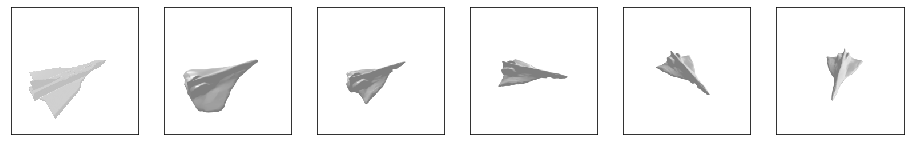

e712867dc4c1a4a6d016d0153a25a372
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e712867dc4c1a4a6d016d0153a25a372.obj


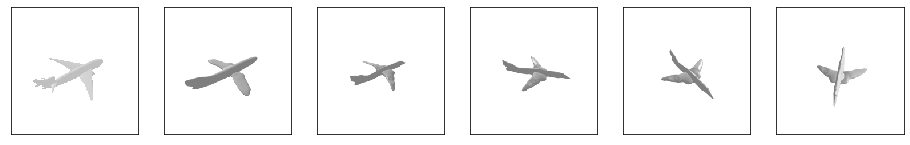

f0b22be59432dc8bca8607f540cc62ba
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f0b22be59432dc8bca8607f540cc62ba.obj


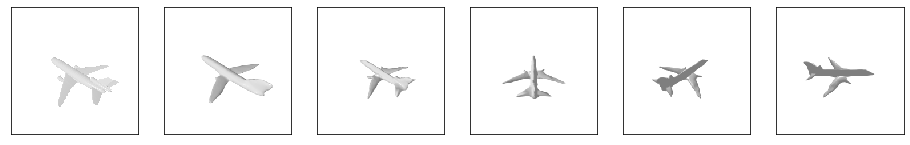

f2171bb2d715140c8b96ae1a0a8b84ec
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f2171bb2d715140c8b96ae1a0a8b84ec.obj


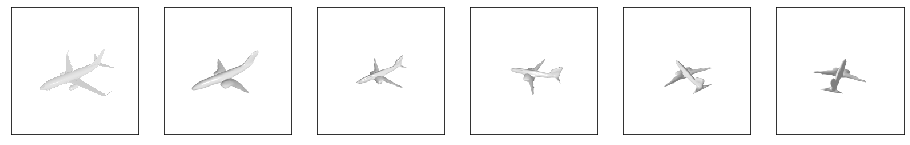

d2c7b95823938833339bd6b570381585
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d2c7b95823938833339bd6b570381585.obj


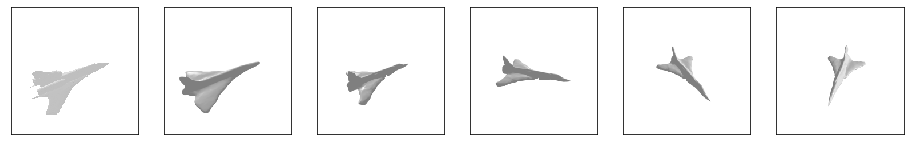

d281db2c631c0170991ade27bbcf967d
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d281db2c631c0170991ade27bbcf967d.obj


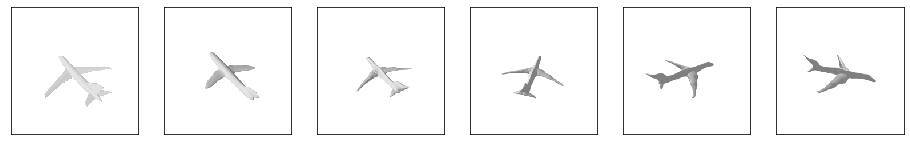

d4aec2680be68c813a116bc3efac4e3b
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d4aec2680be68c813a116bc3efac4e3b.obj


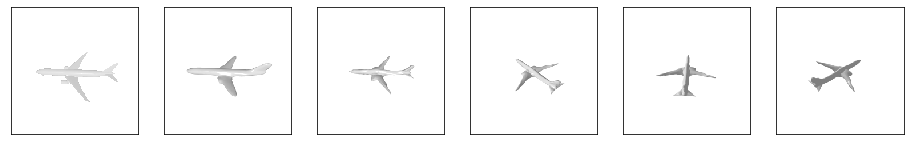

ed0a9a32a8e35f21ca8607f540cc62ba
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/ed0a9a32a8e35f21ca8607f540cc62ba.obj


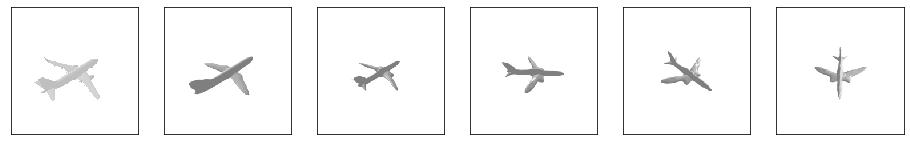

e1e5cfcabcbe26a03087f84b199fd297
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e1e5cfcabcbe26a03087f84b199fd297.obj


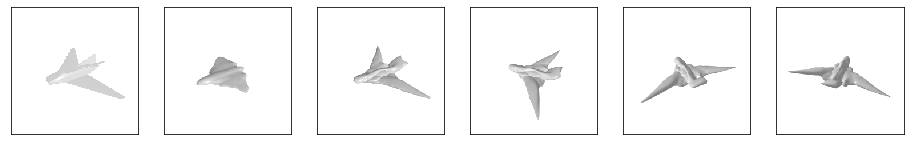

e559a626d0ef8b4f982014dd9aabdeeb
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e559a626d0ef8b4f982014dd9aabdeeb.obj


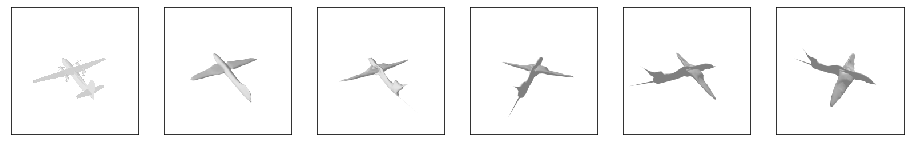

fd3a9743e16d35e51fc210a07910eb2
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/fd3a9743e16d35e51fc210a07910eb2.obj


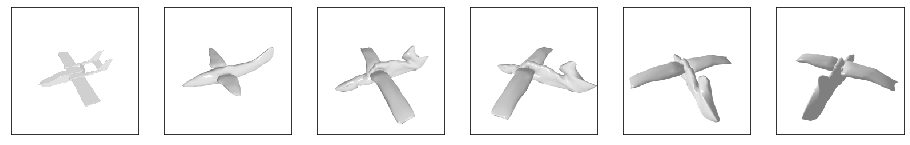

e52f08852429e6117dc01d89d8a05b74
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/e52f08852429e6117dc01d89d8a05b74.obj


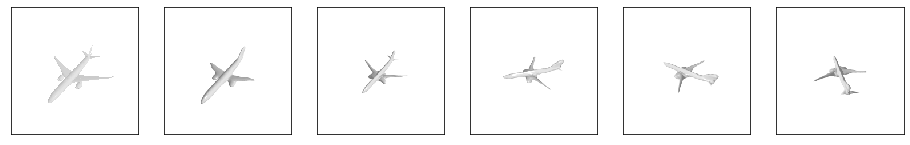

f7f915160c0e1f6f42bc0eea174f82b
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f7f915160c0e1f6f42bc0eea174f82b.obj


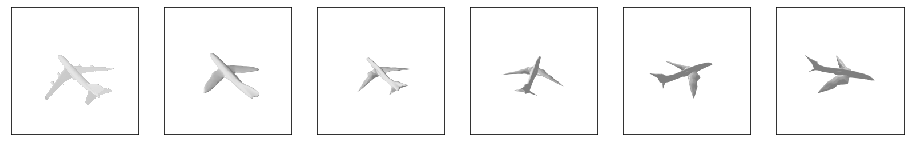

d708c311bcd60e61c9ac656f0c2edc4b
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/d708c311bcd60e61c9ac656f0c2edc4b.obj


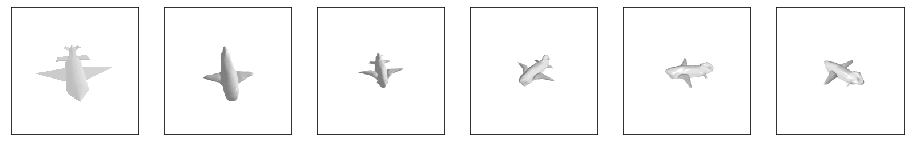

fff513f407e00e85a9ced22d91ad7027
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/fff513f407e00e85a9ced22d91ad7027.obj


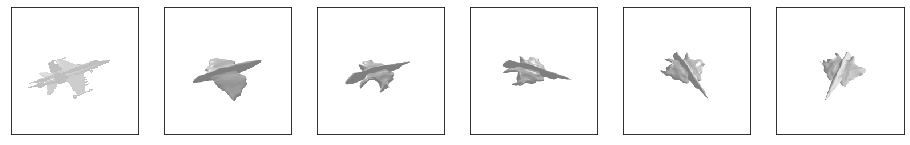

df9d8ab5ab6f50ed4d4cb1c2a5e48b7a
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/df9d8ab5ab6f50ed4d4cb1c2a5e48b7a.obj


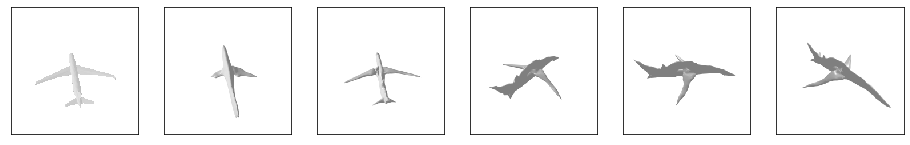

f6ec20afe98e37ef6e2a24768a2fccc
out/2020_12_29--05_03_37_airplane_job_05/eval_0630/f6ec20afe98e37ef6e2a24768a2fccc.obj


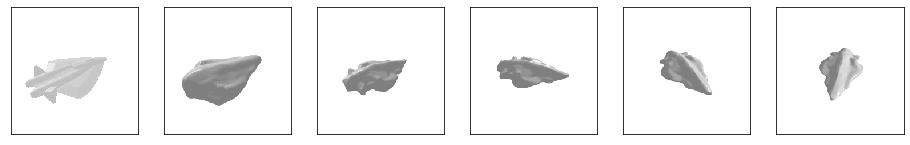

In [9]:
# show all latest meshes
eval_dirs = []
for root, dirs, files in os.walk(saved_model_path):
    for d in dirs:
        if "eval_" in d:
            eval_dirs.append(d)
eval_dirs = sorted(eval_dirs, key= lambda x: int(x.replace("eval_", "")))
latest_eval_dir = os.path.join(saved_model_path, eval_dirs[-1])
print("Latest eval dir: {}\n".format(latest_eval_dir))

show_meshes(cfg, device, latest_eval_dir, print_instances=True)

d4326cd55ed8333f6a059e1fc701f06
out/2020_12_19--08_53_55_job_14/eval_0495/d4326cd55ed8333f6a059e1fc701f06.obj


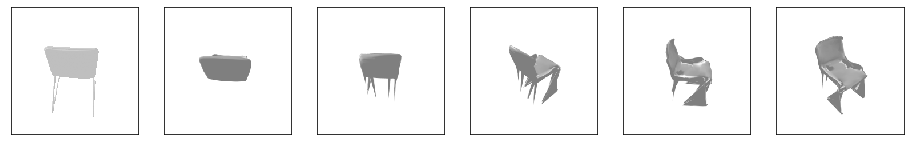

d1291956cb0983ee7085b4353236aad
out/2020_12_19--08_53_55_job_14/eval_0595/d1291956cb0983ee7085b4353236aad.obj


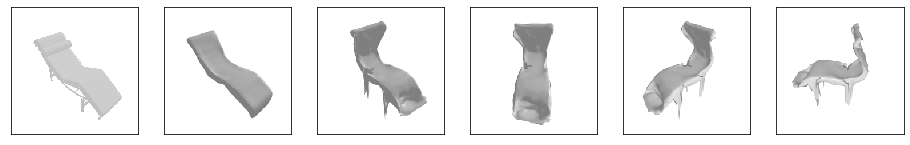

ee4858f78dc33591100e9bd5c4b0af54
out/2020_12_19--08_53_55_job_14/eval_0535/ee4858f78dc33591100e9bd5c4b0af54.obj


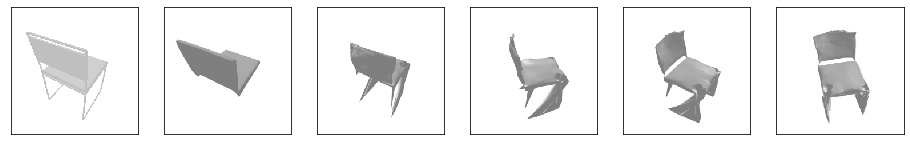

d30e58a2361785683fb0851e9bc87551
out/2020_12_19--08_53_55_job_14/eval_0420/d30e58a2361785683fb0851e9bc87551.obj


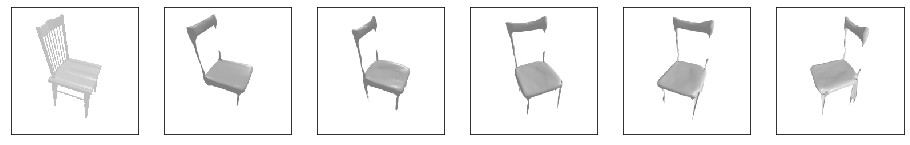

d20de927fd1b15ef104c86562c321749
out/2020_12_19--08_53_55_job_14/eval_0345/d20de927fd1b15ef104c86562c321749.obj


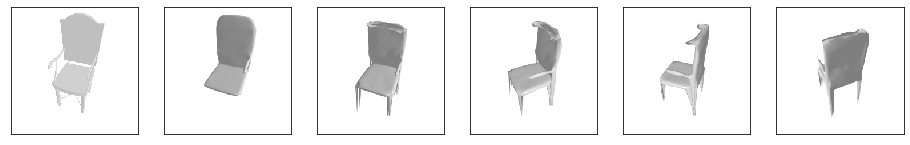

e7d4a3cca8edfde4829113e62386fd50
out/2020_12_19--08_53_55_job_14/eval_0545/e7d4a3cca8edfde4829113e62386fd50.obj


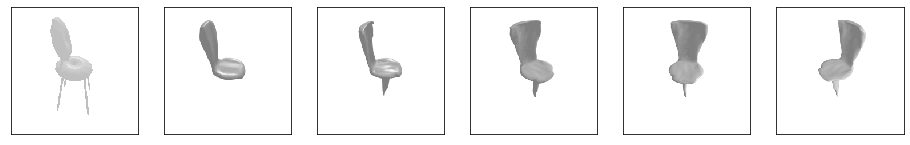

d97a4a6f84f40854f51fa0238791f5dc
out/2020_12_19--08_53_55_job_14/eval_0535/d97a4a6f84f40854f51fa0238791f5dc.obj


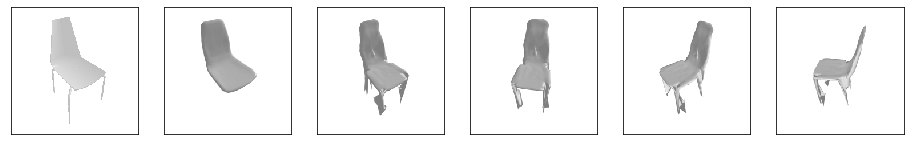

d6ac690c293a492d2d2a5d4c4022b4c6
out/2020_12_19--08_53_55_job_14/eval_0565/d6ac690c293a492d2d2a5d4c4022b4c6.obj


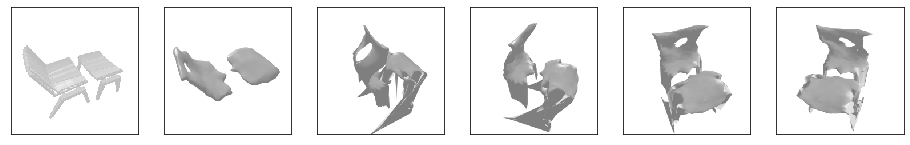

ce9cedc58c77aab4b5a19b1840ec7af
out/2020_12_19--08_53_55_job_14/eval_0565/ce9cedc58c77aab4b5a19b1840ec7af.obj


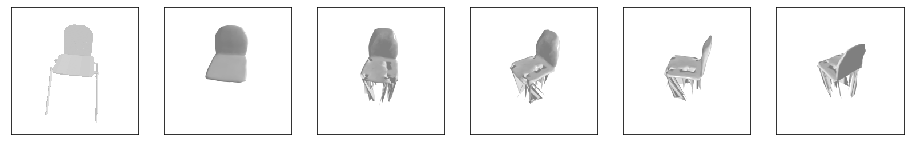

e0efbc4e240b9cc235836c728d324152
out/2020_12_19--08_53_55_job_14/eval_0585/e0efbc4e240b9cc235836c728d324152.obj


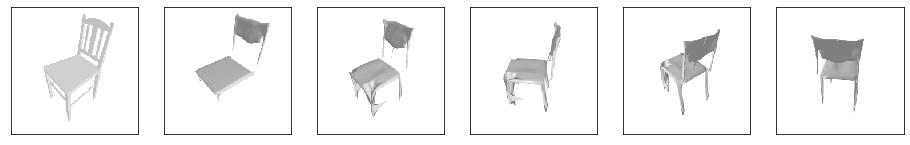

In [13]:
# show a mesh throughout iterations
#instances_to_show = ["ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749"]
#instances_to_show = ["e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]
instances_to_show = ["d30e58a2361785683fb0851e9bc87551", "cc25ba35b3f6e8d3d064b65ccd89778c", "d4326cd55ed8333f6a059e1fc701f06", "d02f9ae175fa83d3e6fe3612af521500", "d1291956cb0983ee7085b4353236aad",
            "ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749",
            "e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]

show_meshes(cfg, device, saved_model_path, instances_to_show, print_instances=True, descending=True)

# New heading

In [ ]:
for i in range(1,19):
    n = ("job_{:02}".format(i))
    saved_model_path = "out/{}".format(get_exp_path(n))
    print(saved_model_path)
    cfg_path = glob.glob(os.path.join(saved_model_path, "job_*.yaml"))[0]
    print(cfg_path)
    cfg = general_utils.load_config(cfg_path, "configs/default.yaml")
    
    # show a mesh throughout iterations
    #instance_to_show = ["ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749"]
    instance_to_show = ["e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]
    show_meshes(cfg, device, saved_model_path, instance_to_show, print_instances=True, descending=True)

    print("=================================================================================================")
    print("=================================================================================================")